In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import Dataset, DataLoader

C:\Users\rpandur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_pickle("audio_data.csv")
df

,feature,class_label
0,"[-603.87335, 112.61716, -102.54007, 5.65595, -...",0
1,"[-628.17114, 128.97488, -113.03311, 2.139047, ...",0
2,"[-627.6933, 127.013985, -118.67326, 4.8988237,...",0
3,"[-641.61084, 115.18, -118.35519, 0.94005626, -...",0
4,"[-652.4254, 121.818886, -116.970375, -2.35829,...",0
5,"[-578.73334, 116.49693, -96.11051, 36.35543, -...",1
6,"[-629.1156, 109.64684, -110.687904, 19.938028,...",1
7,"[-618.5125, 108.39749, -116.07095, 13.16094, -...",1
8,"[-621.2998, 112.87354, -114.72194, 15.34196, -...",1
9,"[-612.47424, 111.00445, -110.74693, 16.38074, ...",1


In [4]:
# df = pd.read_pickle("final_audio_data_csv/audio_data.csv")

X = df["feature"].values
X = np.concatenate(X, axis=0).reshape(len(X), 40)
y = np.array(df["class_label"].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)

In [5]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)#.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
   
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


Batch: 1
X shape: torch.Size([6, 40])
y shape: torch.Size([6])


In [7]:
XX = torch.from_numpy(X_train)
XX.size()[-1]

40

In [5]:
n_input_dim = X_train.shape[1]

#Layer size
n_hidden1 = 30  # Number of hidden nodes
n_hidden2 = 10
n_output =  1   # Number of output nodes = for binary classifier

class ClfModel(nn.Module):
    def __init__(self):
        super(ClfModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
model = ClfModel()
print(model)

ClfModel(
  (layer_1): Linear(in_features=40, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [6]:
learning_rate = 0.01
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 500
loss_values = []

model.train()
for epoch in range(num_epochs):
    for X, y in train_dataloader:
        y_pred = model(X)            # Forward Propagation
        loss = loss_fn(y_pred, y.unsqueeze(-1))  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
    loss_values.append(loss.item())
        
print("Training Complete")

Training Complete


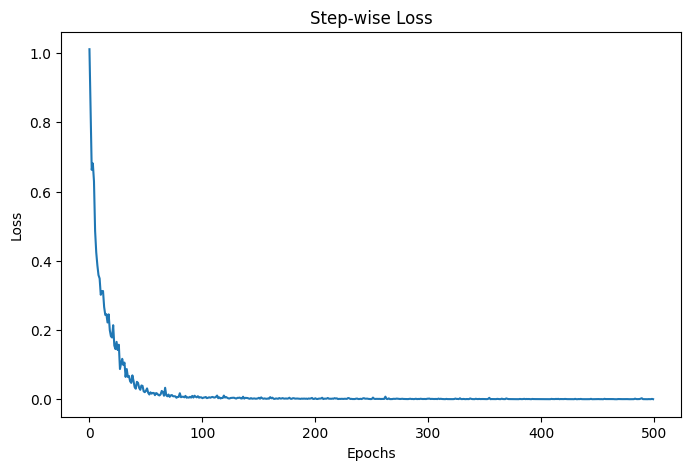

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [8]:
import itertools
y_pred = []
y_test = []
total, correct = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy test instances: {100 * correct // total}%')


Accuracy test instances: 50%


In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns


y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         1
         1.0       1.00      0.33      0.50         3

    accuracy                           0.50         4
   macro avg       0.67      0.67      0.50         4
weighted avg       0.83      0.50      0.50         4



In [24]:
torch.save(model.state_dict, 'saved_model/model.pt')

In [23]:
model_from_path = torch.load('saved_model/model.pt')

In [40]:
######## IMPORTS ##########
import sounddevice as sd
from scipy.io.wavfile import write
import librosa
import numpy as np
import torch
from torch import nn

import os
os.chdir(r'C:\Users\rpandur\Documents\Courses\ML_From_Scratch-master\Misc\wake_word\WakeWordDetection')


In [41]:


####### ALL CONSTANTS #####
fs = 44100
seconds = 2
filename = "prediction.wav"
class_names = ["Wake Word NOT Detected", "Wake Word Detected"]

n_hidden1 = 30  # Number of hidden nodes
n_hidden2 = 10
n_output =  1
n_input_dim = 40


In [53]:
class ClfModel(nn.Module):
    def __init__(self):
        super(ClfModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        # x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        # x = self.batchnorm2(x)
        # x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
model = ClfModel()


In [54]:
##### LOADING OUR SAVED MODEL and PREDICTING ###
model.load_state_dict(torch.load("saved_model/model.pt"))
# model = torch.load("saved_model/model.pt")

print("Prediction Started: ")

Prediction Started: 


In [60]:

# i = 0
# while True:
print("Say Now: ")
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()
write(filename, fs, myrecording)

audio, sample_rate = librosa.load(filename)
mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfcc_processed = np.mean(mfcc.T, axis=0)
mfcc_processed = torch.from_numpy(mfcc_processed).reshape(1, -1)

Say Now: 


In [65]:
prediction.item()

0.9982444047927856

In [66]:
prediction = model(mfcc_processed)
if prediction.item() > 0.99:
    print(f"Wake Word Detected for ({i})")
    print("Confidence:", prediction[:, 1])
    i += 1

else:
    print(f"Wake Word NOT Detected")
    print("Confidence:", prediction[:, 0])


NameError: name 'i' is not defined